![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

# Max-volume axis-parallel cuboid inscribed in a Regular Icosahedron

This notebook presents an exercise in using affine conic constraints and the geometric mean cone (introduced as a standalone domain in v10). We implement the maximum volume cuboid example discussed in the MOSEK modelling cookbook, section 4.3.2.

In the current example, we seek the maximal volume, axis-parallel cuboid inscribed within a [Regular Icosahedron](https://en.wikipedia.org/wiki/Regular_icosahedron). Note that a max-volume cuboid (not necessarily axis-parallel) will lead to a non-convex problem. That will not be the scope of this notebook.

The model to implement is:

\begin{align}
& \max & & t \nonumber \\
& \textrm{s.t.} & & t \leq (x_1 \cdots x_n)^{1/n} \label{opt_prob:max_vol_cuboid} \tag{1}\\
& & & p + E^i \cdot x = u_1^iv_1 + \cdots + u_m^iv_m & \forall i=1,\cdots,2^n \\
& & & \sum_{j=1}^{m}u_j^i = 1 & \forall i=1,\cdots,2^n \\
& & & x\geq0\, , \, u\geq0 \nonumber \\
\end{align}


where $E^i$ is a diagonal matrix such that $\text{diag}(E^i) = e^i$ and $e^i$ is a vector of 1's and 0's enumerating the $i$-th vertex of the inscribed cuboid ($i=1,\cdots,2^n$ in $\mathbb{R}^n$). The variable vector $x$ represents the edge lengths of the cuboid; $p$ is the left-most vertex of the cuboid. Note that $\text{diag}(e^i)\cdot x$ denotes the element-wise multiplication of the $e_i$ and $x$ vectors.

Given the vertices ($v_1, \cdots, v_m$), the icosahedron (with $m=12$) can be represented by the convex hull formed using its vertices. This is implemented in the second and the third constraints.

The objective value is the $n$-th root of the volume of the inscribed cuboid.

It is the first constraint that will be implemented using the primal geometric mean cone. 

As an exercise, the reader is encouraged to find an alternative implementation using the power cone.

## Optimizer API

The mathematical statement of the problem in a matrix-focused perspective is as follows: 

\begin{align*}
\max & \quad \quad t  \\
\\
\textrm{s.t.} & \quad \quad \left[\begin{array}{c c c}
                             1 &\cdots&0\\
                             \vdots &\ddots&\vdots\\
                             0&\cdots& 1\end{array}\right]\left[\begin{array}{c} \vdots \\ x_n \\ t\end{array} \right]  \in \mathbb{K}^{n+1}_{\text{GEO}} \\ 
                             & \\
              & \quad \quad \left[\begin{array}{}
                             e^i_1 &\cdots& 0    & \vdots& 1    &\cdots& 0    &&\cdots&&-v^1_1&\cdots &-v^1_m\\
                             \vdots&\ddots&\vdots& 0     &\vdots&\ddots&\vdots&&\cdots&&\vdots&\cdots&\vdots\\
                             0 &\cdots    & e^i_n& \vdots & 0    &\cdots& 1   &&\cdots&&-v^n_1&\cdots&-v^n_m\\
                             &\cdots&&0&&\cdots&&&\cdots&&1 & \cdots & 1 \end{array}\right]\left[\begin{array}{c} x\\ t \\ p\\ \vdots\\ u\end{array} \right] + 
                    \left[\begin{array}{c} 0 \\\vdots \\ \vdots \\0 \\ -1\end{array}\right] \in \mathbb{R}^{n+1}_{0} & \forall i=1,\cdots,2^n \\
               & \quad \quad  x\geq0\, , \, u\geq0 \nonumber \\
\end{align*}

### Vertices of a Regular icosahedron

In [1]:
import sys
import itertools
import numpy as np

# Vertices of a regular icosahedron with edge length 2
f = (1+np.sqrt(5))/2
icosahedron = np.array([[ 0, 1, f],[ 0,-1, f],[ 0, 1,-f],[ 0,-1,-f],[ 1, f, 0],[ 1,-f, 0],
                        [-1, f, 0],[-1,-f, 0],[ f, 0, 1],[-f, 0, 1],[ f, 0,-1],[-f, 0,-1]])
print(f"Volume of the icosahedron = {2.18169699*8}")

Volume of the icosahedron = 17.45357592


## Install MOSEK 10 and set license in Google Colab (30 days validity!)

In [3]:
# Download and install MOSEK 10 into Colab environment
!wget https://download.mosek.com/beta/wheel/Mosek-10.0.17-cp37-cp37m-manylinux2014_x86_64.whl
!pip install Mosek-10.0.17-cp37-cp37m-manylinux2014_x86_64.whl

# TEMPORARY TRIAL LICENSE #
import os 
os.environ["MOSEKLM_LICENSE_FILE"]="""START_LICENSE\n
VENDOR MOSEKLM
FEATURE PTS MOSEKLM 10.00 26-aug-2022 uncounted \
	VENDOR_STRING=-1*-1*-1*0 HOSTID=ANY SN=1 TS_OK SIGN="1032 E2C3 \
	E627 A2E4 FED2 B039 0EE1 6938 CAEB 9AEA 9CE7 F604 262B BD8B \
	87E6 1D51 5BC2 C7AC 0419 ED52 C9F0 3B94 BB2C 24BB DD61 7568 \
	9484 788C 5D87 8CAC" SIGN2="1459 EAA7 2414 4576 9096 1FB3 66BE \
	2B24 45C1 BD1A 91EB 5BCC 4BC9 77C9 F0E0 05C7 B876 51C6 EBC2 \
	3906 0822 A1F7 10B6 7A51 B131 2682 D856 EEAE 9E60 C84B"
FEATURE PTON MOSEKLM 10.00 26-aug-2022 uncounted \
	VENDOR_STRING=-1*-1*-1*0 HOSTID=ANY SN=1 TS_OK SIGN="1440 BC33 \
	74AA 432C 059D 85E3 CBD4 4E72 F3EF 5DF7 B89F 6D90 485B 8B4C \
	07ED 07DC 3995 FE75 FF37 1CF1 2BF9 D8E0 C473 48DE 14E9 DB2F \
	5666 7C31 E556 1F91" SIGN2="0846 DF43 2D45 E382 A875 A7B2 AE04 \
	16E1 D495 32F0 BF59 7A63 DEA2 825D 518C 0E8A 2825 02C2 8D1A \
	C6AF CB46 C30F BD60 D03E 3F2F CB8C EB40 862A 935C B746"
    END_LICENSE\n
"""

### Formulation

In [4]:
from mosek import *

inf = 0.0 # Symbolic constant (value irrelevant)

def streamprinter(text):
    sys.stdout.write(text)
    sys.stdout.flush()
    
def convexHullConstraint(task, p_v, c_v, dom):
    m, n = len(p_v), len(p_v[0])
    nvar, nafe = task.getnumvar(), task.getnumafe()
    # VARIABLES: dim(u) = m
    task.appendvars(m)
    task.putvarboundsliceconst(nvar, nvar+m, boundkey.lo, 0, inf)
    # Append n+1 affine expressions to the task.
    task.appendafes(n+1)
    for i in range(n):
        task.putafefrow(nafe + i, 
                        [i, i+n+1] + list(range(nvar, nvar+m)),
                        [c_v[i], 1.0] + list(-p_v[:, i]))
    task.putafefrow(nafe + n, 
                    range(nvar, nvar+m),
                    [1.0]*m)
    task.putafeg(nafe + n, -1)
    # Construct the ACC
    task.appendacc(dom, range(nafe, nafe+n+1), None)

def OPT_MaxVolCuboid(polyhedron):
    m = len(polyhedron)
    n = len(polyhedron[0])

    cuboid = list(itertools.product([0,1], repeat = n))

# MOSEK TASK
    task = Task()
    task.set_Stream(streamtype.log, streamprinter)
    
# VARIABLES: dim(x) = n; dim(t) = 1; dim(p) = n
    task.appendvars(2*n+1) 
    task.putvarboundsliceconst(0, n, boundkey.lo, 0, inf)
    task.putvarboundsliceconst(n, 
                               2*n+1, 
                               boundkey.fr, -inf, inf)

# OBJECTIVE: maximize t
    task.putcj(n, 1)
    task.putobjsense(objsense.maximize)
    
# ACCs
# GEOMETRIC MEAN CONE:
    # 1. AFE
    task.appendafes(n+1)
    task.putafefentrylist(range(n+1), 
                          range(n+1), 
                          [1.0]*(n+1))
    # 2. Domain
    geo_cone = task.appendprimalgeomeanconedomain(n+1)
    # 3. AFE \in Domain --> ACC
    task.appendacc(geo_cone, range(n+1), None)
    
# CONVEX HULL CONSTRAINTS:
    # Re-use this domain instance for all ACCs hereafter.
    r_zero = task.appendrzerodomain(n+1)
    
    # One ACC for each vertex of the cuboid
    for i, c_v in enumerate(cuboid):
        convexHullConstraint(task, polyhedron, c_v, r_zero)
    
# OPTIMIZE:
    task.optimize()
    task.solutionsummary(streamtype.msg)
    
    solution = task.getxx(soltype.itr)
    x, t, p = np.array(solution[:n]), solution[n], np.array(solution[n+1:2*n+1])
    cuboid_vertices = np.array([ p + e*x for e in cuboid ])
    
    print(f"\nVolume of the inscribed cuboid = {t**n}" )
    return cuboid_vertices

# Solve the model 
cuboid = OPT_MaxVolCuboid(icosahedron)

Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 0               
  Affine conic cons.     : 9               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 103             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Obj

<IPython.core.display.Javascript object>


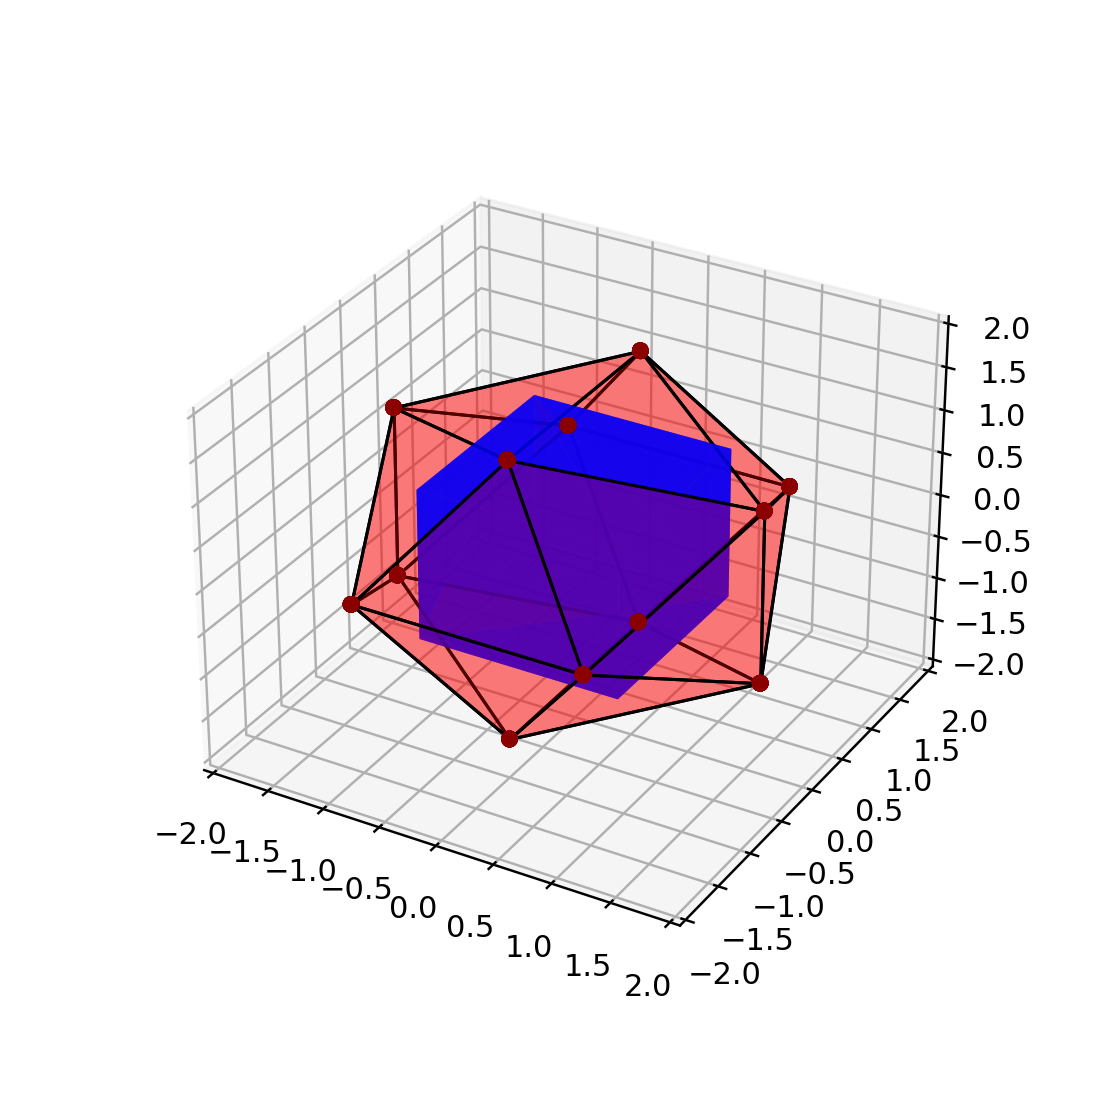

In [5]:
# Make an interactive 3-D plot of the regular 
# icosahedronincribed and the inscribed cuboid
# using the vertices of each.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
%matplotlib inline

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
  
configure_plotly_browser_state()

def inscribed_cuboid_plot(icosahedron, cuboid):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection="3d")

    ico_hull = ConvexHull(icosahedron)
    for s in ico_hull.simplices:
        tri = Poly3DCollection([icosahedron[s]])
        tri.set_edgecolor('black')        
        tri.set_alpha(0.3)
        tri.set_facecolor('red')
        ax.add_collection3d(tri)
        ax.scatter(icosahedron[:, 0], icosahedron[:, 1], icosahedron[:, 2], color='darkred')

    cub_hull = ConvexHull(cuboid)
    for s in cub_hull.simplices:
        tri = Poly3DCollection([cuboid[s]])
        #tri.set_edgecolor('black')        
        tri.set_alpha(0.8)
        tri.set_facecolor('blue')
        ax.add_collection3d(tri)

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    plt.show()

# Draw the 3-D interactive plot using cuboid vertices
inscribed_cuboid_plot(icosahedron, cuboid)

# Fusion API

Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 32              
  Affine conic cons.     : 1               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 104             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Obj

<IPython.core.display.Javascript object>


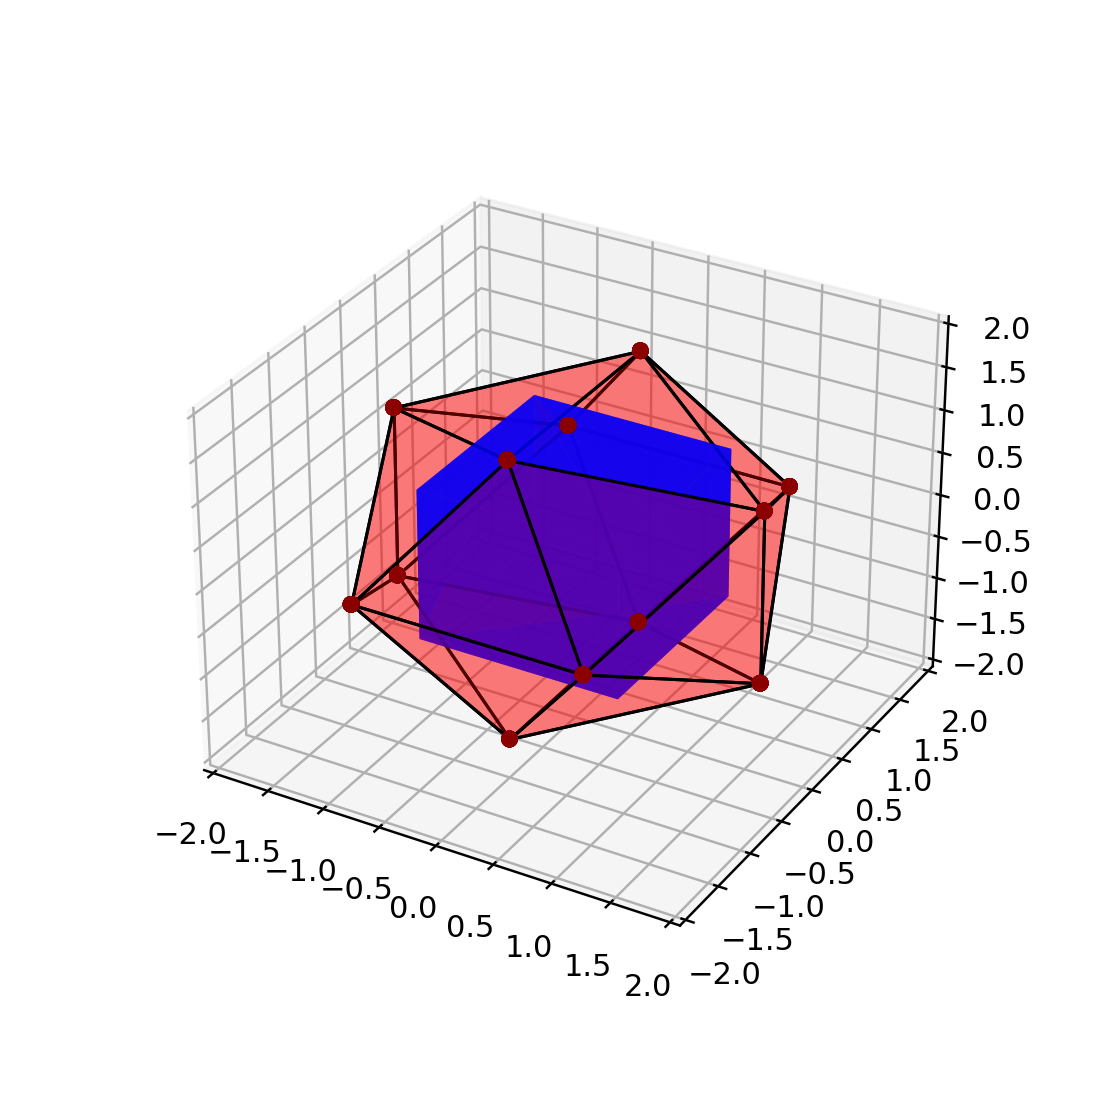

In [6]:
# Find the maximum volume cuboid inscribed within a closed polyhedron
# 
# vertices (m*n shaped numpy array) : vertices of a convex polyhedron
from mosek.fusion import *

def FUS_MaxVolCuboid(vertices):
    m = len(vertices)                                   # Number of vertices
    n = len(vertices[0])                                # R^n
    cuboid = list( itertools.product([0, 1], repeat=n))    # cuboid vertices (eg. 000, 001, ..., 111)
    
    M = Model()
    M.setLogHandler(sys.stdout)
        
    x = M.variable('x', n, Domain.greaterThan(0))
    p = M.variable('p', n)
    t = M.variable('t')

    # Maximize: (volume_of_cuboid)**1/n
    M.objective(ObjectiveSense.Maximize, t)
    M.constraint('obj', Expr.vstack(x, t), Domain.inPGeoMeanCone())

    # K : convex hull from vertices
    u = M.variable('u', [m, 2**n], Domain.greaterThan(0))
    M.constraint(Expr.sum(u, 0), Domain.equalsTo(1.0))
    for i, c_v in enumerate(cuboid):
        # i-th vertex of the cuboid 
        V = Expr.add(p, Expr.mulElm(list(c_v[:]), x))
        # i-th vertex \in K
        K = Expr.vstack([ Expr.dot( u.slice([0,i],[m,i+1]), vertices[:,j]) for j in range(n)])
        M.constraint('v_{}'.format(c_v), Expr.sub(V, K), Domain.equalsTo(0))
    
    M.solve()
    print(f" \nVolume of cuboid = {M.primalObjValue()**n}")
    x_0 = x.level()
    p_0 = p.level()
    
    cuboid_vertices = np.array([ p_0 + e*x_0 for e in cuboid ])
    return cuboid_vertices

cuboid = FUS_MaxVolCuboid(icosahedron)
inscribed_cuboid_plot(icosahedron, cuboid)

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 